## Vizualise Textual Embeddings of Symbols Meaning Landscape and Dream Content  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from shapely.geometry import MultiPoint
from scipy.spatial import ConvexHull
from transformers import CLIPTokenizer, CLIPModel
import torch
import seaborn as sns


def map_words_to_semantic_space(word_dict, scaling_factor=2000, dim_red="tsne", savefig=False, savename='test'):
    # Load CLIP model and tokenizer
    model_name = "openai/clip-vit-base-patch32"
    tokenizer = CLIPTokenizer.from_pretrained(model_name)
    model = CLIPModel.from_pretrained(model_name)

    # Combine all words across authors
    all_words = []
    labels = []
    for author, words in word_dict.items():
        all_words.extend(words)
        labels.extend([author] * len(words))

    # Calculate embeddings for all words
    word_vectors = []
    for word in all_words:
        tokenized = tokenizer(word, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            embedding = model.get_text_features(**tokenized)
        word_vectors.append(embedding.squeeze(0).numpy())

    word_vectors = np.array(word_vectors)

    # Dimensionality reduction
    if dim_red == "tsne":
        dim_red_model = TSNE(n_components=2, perplexity=6, random_state=42)
        word_vectors_2d = dim_red_model.fit_transform(word_vectors)
    else:
        raise ValueError(f"Invalid value for dim_red: {dim_red}. Only 'tsne' is supported.")

    # Create scatter plot and calculate convex hulls
    plt.figure(figsize=(10, 10))
    unique_authors = list(set(labels))
    colors = ['red', 'blue', 'green', 'purple', 'cyan', 'yellow', 'black', 'magenta', 'olive', 'navy', 'teal', 'lime', 'maroon']
    markers = ['.', ',', 'o', 'v', '^', '<', '>', 's', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd']
    archetype_hulls = {}

    for i, author in enumerate(unique_authors):
        author_indices = [j for j, label in enumerate(labels) if label == author]
        x = word_vectors_2d[author_indices, 0]
        y = word_vectors_2d[author_indices, 1]
        archetype_points = MultiPoint([(x[j], y[j]) for j in range(len(x))])
        area = archetype_points.convex_hull.area
        print(author, 'area:', area)
        archetype_hulls[author] = archetype_points.convex_hull
        plt.scatter(x, y, marker=markers[i % len(markers)], alpha=0.5, color=colors[i], label=author)

        # Annotate each word on the scatter plot
        for j, word in enumerate(np.array(all_words)[author_indices]):
            plt.annotate(word, (x[j], y[j]), fontsize=8, ha='center', va='center', color='black')

    for e, (author, hull) in enumerate(archetype_hulls.items()):
        plt.fill(*zip(*hull.exterior.coords), alpha=0.2, color=colors[e])

    plt.legend(title='Archetypes', fontsize=12, title_fontsize=14, loc='upper right')
    plt.title('CLIP Word Embeddings Visualized')

    if savefig:
        plt.savefig(savename + '.png', dpi=300)
    else:
        plt.show()

    return archetype_hulls




def plot_archetype_heatmap(archetype_hulls):
    archetypes = list(archetype_hulls.keys())
    num_archetypes = len(archetypes)
    heatmap = np.zeros((num_archetypes, num_archetypes))

    for i in range(num_archetypes):
        for j in range(num_archetypes):
            if i >= j:
                continue
            hull1 = MultiPoint([point for point in archetype_hulls[archetypes[i]].exterior.coords])
            hull2 = MultiPoint([point for point in archetype_hulls[archetypes[j]].exterior.coords])
            intersection = hull1.convex_hull.intersection(hull2.convex_hull).area
            heatmap[i, j] = intersection
            heatmap[j, i] = intersection

    mask = np.triu(np.ones_like(heatmap, dtype=bool))
    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap, mask=mask, annot=True, fmt=".2f", cmap="viridis", xticklabels=archetypes, yticklabels=archetypes)
    plt.title("Shared Areas Between Symbols")
    plt.show()




c:\Users\User\anaconda3\envs\goofi\lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
c:\Users\User\anaconda3\envs\goofi\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\User\anaconda3\envs\goofi\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


BAG area: 3700.62
LIGHTNING area: 5639.88
HORSE TRACK area: 1691.90
STAR area: 4371.13
FEATHER area: 2714.47
EARTH area: 4177.53
DRAGONFLY area: 3918.35
HOUSE area: 2004.57
CLOUDS area: 5256.64
THUNDER area: 3800.93


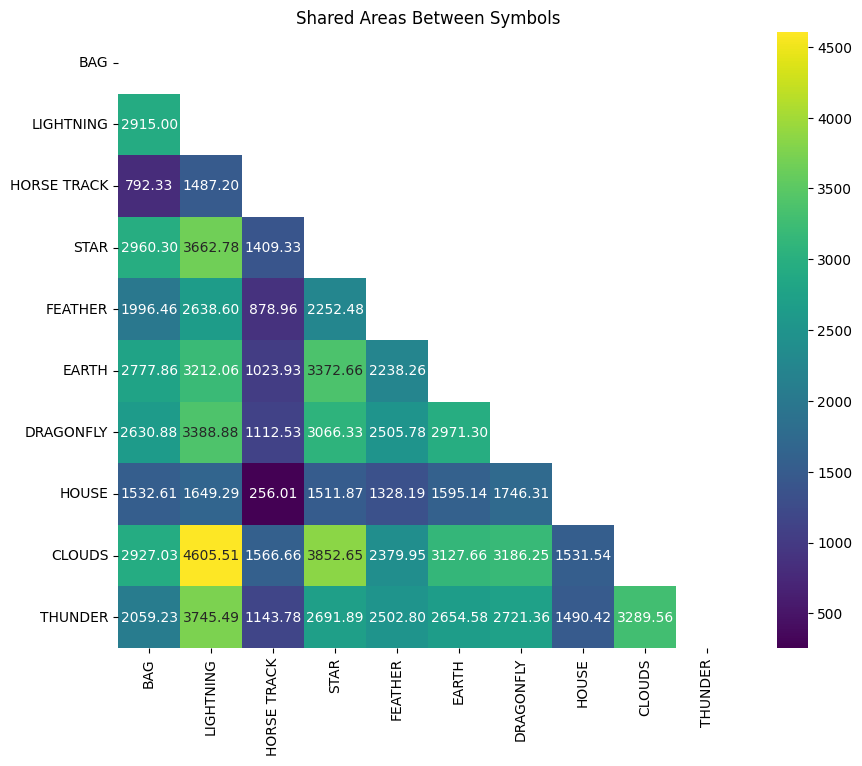

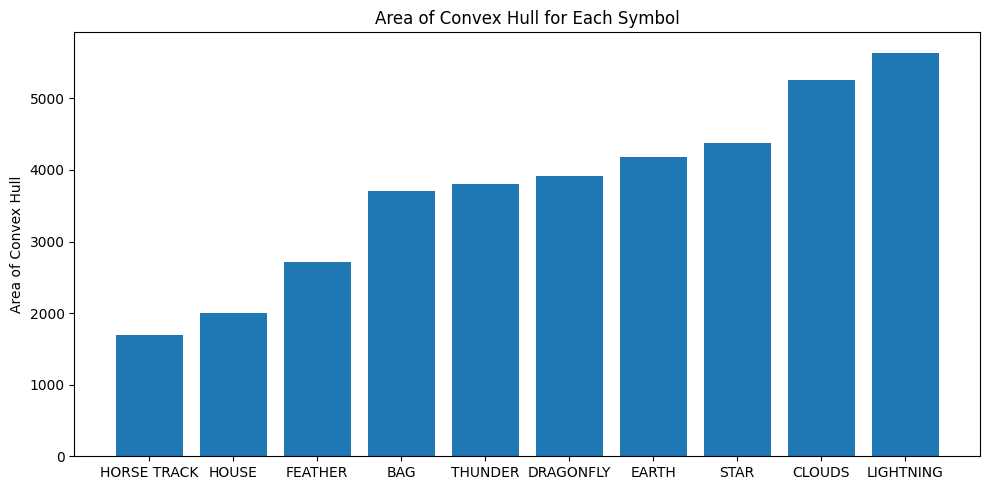

In [2]:
import numpy as np
import plotly.graph_objects as go
from sklearn.manifold import TSNE
from shapely.geometry import MultiPoint
from scipy.spatial import ConvexHull
from transformers import CLIPTokenizer, CLIPModel
import torch
from sklearn.decomposition import PCA
from umap import UMAP
import seaborn as sns


def map_words_to_semantic_space_dynamic(word_dict, scaling_factor=2000, dim_red="tsne", perplexity=6):
    # Load CLIP model and tokenizer
    model_name = "openai/clip-vit-base-patch32"
    tokenizer = CLIPTokenizer.from_pretrained(model_name)
    model = CLIPModel.from_pretrained(model_name)

    # Combine all words across archetypes
    all_words = []
    labels = []
    for archetype, words in word_dict.items():
        all_words.extend(words)
        labels.extend([archetype] * len(words))

    # Calculate embeddings for all words
    word_vectors = []
    for word in all_words:
        tokenized = tokenizer(word, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            embedding = model.get_text_features(**tokenized)
        word_vectors.append(embedding.squeeze(0).numpy())

    word_vectors = np.array(word_vectors)

    # Dimensionality reduction
    # Dimensionality reduction
    if dim_red == "tsne":
        dim_red_model = TSNE(n_components=2, perplexity=perplexity, random_state=42)
        word_vectors_2d = dim_red_model.fit_transform(word_vectors)
    elif dim_red == "pca":
        dim_red_model = PCA(n_components=2)
        word_vectors_2d = dim_red_model.fit_transform(word_vectors)
    elif dim_red == "umap":
        dim_red_model = UMAP(n_components=2, random_state=42)
        word_vectors_2d = dim_red_model.fit_transform(word_vectors)
    else:
        raise ValueError(f"Invalid value for dim_red: {dim_red}. Supported values: 'tsne', 'pca', 'umap'.")

    return word_vectors_2d, labels, all_words, word_vectors


def create_dynamic_plot(word_vectors_2d, labels, all_words):
    # Create a Plotly figure
    fig = go.Figure()

    unique_archetypes = list(set(labels))
    base_colors = [
        'rgba(255, 0, 0, 1)',    # Red
        'rgba(0, 0, 255, 1)',    # Blue
        'rgba(0, 255, 0, 1)',    # Green
        'rgba(128, 0, 128, 1)',  # Purple
        'rgba(0, 255, 255, 1)',  # Cyan
        'rgba(255, 255, 0, 1)',  # Yellow
        'rgba(0, 0, 0, 1)',      # Black
        'rgba(255, 0, 255, 1)',  # Magenta
        'rgba(128, 128, 0, 1)',  # Olive
        'rgba(0, 0, 128, 1)',    # Navy
        'rgba(0, 128, 128, 1)',  # Teal
        'rgba(0, 128, 0, 1)',    # Lime
    ]

    archetype_hulls = {}
    areas = {}
    for i, archetype in enumerate(unique_archetypes):
        # Get points for the current archetype
        archetype_indices = [j for j, label in enumerate(labels) if label == archetype]
        x = word_vectors_2d[archetype_indices, 0]
        y = word_vectors_2d[archetype_indices, 1]

        # Calculate convex hull and area
        archetype_points = MultiPoint([(x[j], y[j]) for j in range(len(x))])
        hull = archetype_points.convex_hull
        area = hull.area
        archetype_hulls[archetype] = hull
        areas[archetype] = area
        print(f"{archetype} area: {area:.2f}")

        # Add scatter plot for archetype points
        fig.add_trace(go.Scatter(
            x=x, y=y,
            mode='markers+text',
            marker=dict(size=10, color=base_colors[i % len(base_colors)], opacity=0.7),
            text=np.array(all_words)[archetype_indices],
            textposition="top center",
            name=f"{archetype} Points",
            legendgroup=archetype,  # Group the points and hull together
            showlegend=True         # Show legend only for the points
        ))

        # Add convex hull for archetype
        if len(x) > 2:  # Only plot hull if it exists
            hull_coords = np.array(hull.exterior.coords)
            fig.add_trace(go.Scatter(
                x=hull_coords[:, 0].tolist() + [hull_coords[0, 0]],
                y=hull_coords[:, 1].tolist() + [hull_coords[0, 1]],
                fill='toself',
                fillcolor=base_colors[i % len(base_colors)].replace('1)', '0.1)'),
                line=dict(color=base_colors[i % len(base_colors)]),
                name=f"{archetype} Hull",
                legendgroup=archetype,  # Group the hull with the points
                showlegend=False        # Do not show a separate legend for the hull
            ))

    # Update plot layout
    fig.update_layout(
        title="Semantic Map with Convex Hulls",
        xaxis_title="Dimension 1",
        yaxis_title="Dimension 2",
        width=900,
        height=800
    )
    # Remove gridlines
    fig.update_xaxes(showgrid=False)
    fig.update_yaxes(showgrid=False)
    # Remove background color
    fig.update_layout(plot_bgcolor='rgba(0,0,0,0)')
    fig.write_html("dynamic_semantic_map.html")
    fig.show()

    return archetype_hulls, areas


lakota_symbols = {
    "BAG": [
        "bag", "movement", "storage", "transport", "physical medicine",
        "spiritual medicine", "peace pipe", "healing", "necessity", "holding",
        "physical travel", "container", "physical protection", "carrying", "journey", "food"
    ],
    "CLOUDS": [
        "clouds", "rain", "spiritual connection", "vision", "spiritual knowledge",
        "spirit world", "portal", "transcendence", "wisdom", "openness of the plane", "vastness"
    ],
    "DRAGONFLY": [
        "dragonfly", "resilience", "ancient connection", "ancestral", "confirmation",
        "message", "spiritual travel", "flight", "astral travel", "lightly", "blessing",
        "patience", "survival"
    ],
    "EARTH": [
        "earth", "people", "animals", "living beings", "plants", "roots", "mother",
        "geography", "mountain", "earthly", "mundane", "physical world", "harmony",
        "life", "sustainability", "balance", "grounding", "anchor", "stability"
    ],
    "FEATHER": [
        "feather", "achievement", "honor", "bravery", "merit", "counting coup",
        "courage", "knowledge", "eagle", "bird", "ceremony", "humbleness", "nobility",
        "virtue", "valor", "strength"
    ],
    "HORSE TRACK": [
        "horse track", "wealth", "travelling", "movement", "path", "motion",
        "riding", "hunting", "abundance", "dowry", "generosity", "west", "mobility"
    ],
    "HOUSE": [
        "house", "nurturing", "protection", "security", "home", "community",
        "matriarchy", "camp", "family", "care", "council", "grandmother", "safety"
    ],
    "LIGHTNING": [
        "lightning", "power", "thunderbird", "sacred clown", "spirituality", "storm",
        "spiritual connection", "electricity", "west", "fear", "grandfather", "danger",
        "goes out of the eyes of the thunderbird"
    ],
    "STAR": [
        "star", "medicine wheel", "four directions", "north", "ancestral connection",
        "stardust in our bones", "elemental", "extraterrestrial", "star people", "soul",
        "source", "light", "outer space", "balance"
    ],
    "THUNDER": [
        "thunder", "storm", "sound", "cry", "rain", "alert", "spirits arrival",
        "humility", "reminder of humanness", "fragility", "vulnerability", "out of the mouth of the thunderbird"
    ]
}


# Map words to semantic space
word_vectors_2d, labels, all_words, word_vectors = map_words_to_semantic_space_dynamic(lakota_symbols, dim_red="tsne", perplexity=15)

# Create dynamic plot
hulls, areas = create_dynamic_plot(word_vectors_2d, labels, all_words)
plot_archetype_heatmap(hulls)

# plot areas as bar chart
areas_ordered = {k: v for k, v in sorted(areas.items(), key=lambda item: item[1])}
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.bar(areas_ordered.keys(), areas_ordered.values())
plt.ylabel("Area of Convex Hull")
plt.title("Area of Convex Hull for Each Symbol")
plt.tight_layout()
plt.show()



### Average Cosine Similarity for each Symbol

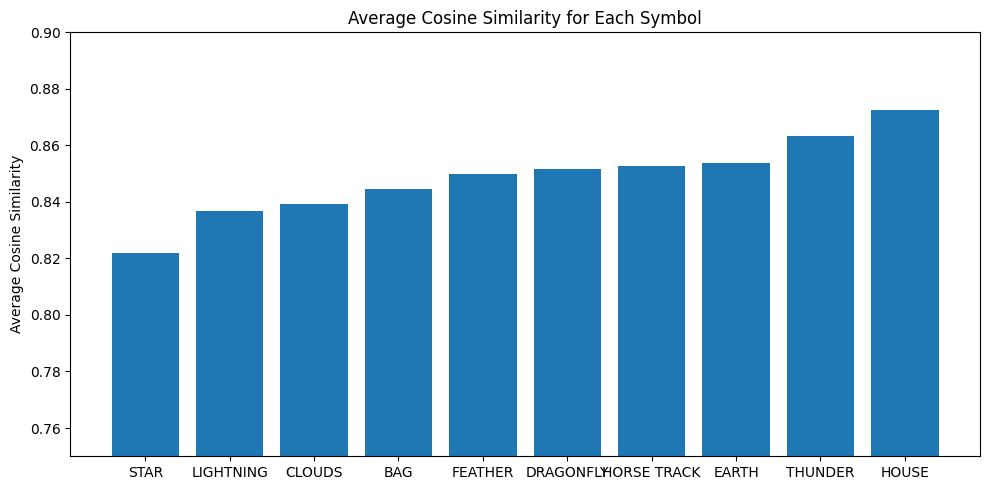

In [57]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def compute_avg_cosine_similarity(word_vectors, labels):
    """
    Compute the average cosine similarity between all word vectors for the same label.
    
    Args:
        word_vectors (ndarray): 2D array of word embeddings.
        labels (list): List of labels corresponding to each word embedding.
    
    Returns:
        dict: Dictionary with symbols as keys and average cosine similarity as values.
    """
    
    unique_labels = set(labels)
    avg_cosine_similarities = {}
    
    for label in unique_labels:
        # Get indices of vectors with the current label
        indices = [i for i, lbl in enumerate(labels) if lbl == label]
        vectors = word_vectors[indices]
        
        # Compute pairwise cosine similarities
        if len(vectors) > 1:
            cosine_sims = cosine_similarity(vectors)
            #print(cosine_sims)
            # Exclude diagonal elements (self-similarity)
            upper_tri_indices = np.triu_indices_from(cosine_sims, k=1)
            avg_cosine_sim = cosine_sims[upper_tri_indices].mean()
        else:
            avg_cosine_sim = 1.0  # Self-similarity for a single vector
        
        avg_cosine_similarities[label] = avg_cosine_sim
    
    return avg_cosine_similarities

avg_cos_sim = compute_avg_cosine_similarity(word_vectors, labels)
avg_cos_sim

# bar plot of average cosine similarity
import matplotlib.pyplot as plt
avg_cos_sim_ordered = {k: v for k, v in sorted(avg_cos_sim.items(), key=lambda item: item[1])}
plt.figure(figsize=(10, 5))
plt.bar(avg_cos_sim_ordered.keys(), avg_cos_sim_ordered.values())
plt.ylabel("Average Cosine Similarity")
plt.title("Average Cosine Similarity for Each Symbol")
plt.ylim(0.75, 0.9)
plt.tight_layout()
plt.show()


## Embedding generation

In [3]:
import numpy as np
import pandas as pd
from transformers import CLIPTokenizer, CLIPModel
from sentence_transformers import SentenceTransformer
import torch
import os

def compute_symbol_embeddings_separate(word_dict, model_name, 
                                       output_mean_dir="mean_embeddings", 
                                       output_max_dir="max_embeddings"):
    """
    Compute one embedding per symbol using mean pooling and max pooling.
    Saves the embeddings as two separate CSV files for each model.
    """
    # Determine the type of model
    if "clip" in model_name.lower():
        # Load CLIP model and tokenizer
        tokenizer = CLIPTokenizer.from_pretrained(model_name)
        model = CLIPModel.from_pretrained(model_name)
        use_clip = True
    else:
        # Load SentenceTransformer model
        model = SentenceTransformer(model_name)
        use_clip = False
    
    # Lists to store embeddings
    mean_embeddings = []
    max_embeddings = []
    symbol_names = []
    
    # Compute embeddings for each symbol
    for symbol, words in word_dict.items():
        word_vectors = []
        for word in words:
            if use_clip:
                # Tokenize and compute embedding using CLIP
                tokenized = tokenizer(word, return_tensors="pt", padding=True, truncation=True)
                with torch.no_grad():
                    embedding = model.get_text_features(**tokenized)
                word_vectors.append(embedding.squeeze(0).numpy())
            else:
                # Compute embedding using SentenceTransformer
                embedding = model.encode(word)
                word_vectors.append(embedding)
            
        word_vectors = np.array(word_vectors)  # Convert to numpy array
        mean_vector = word_vectors.mean(axis=0)  # Mean pooling
        max_vector = word_vectors.max(axis=0)   # Max pooling
        
        # Append to lists
        mean_embeddings.append(mean_vector)
        max_embeddings.append(max_vector)
        symbol_names.append(symbol)
    
    # Convert to 2D NumPy arrays
    mean_embeddings = np.array(mean_embeddings)  # Shape: (symbols, dimensions)
    max_embeddings = np.array(max_embeddings)
    
    # Ensure output directories exist
    os.makedirs(output_mean_dir, exist_ok=True)
    os.makedirs(output_max_dir, exist_ok=True)
    
    # Construct output filenames
    sanitized_model_name = model_name.replace('/', '_').replace('-', '_')
    mean_csv_filename = os.path.join(output_mean_dir, f"{sanitized_model_name}_mean_embeddings.csv")
    max_csv_filename = os.path.join(output_max_dir, f"{sanitized_model_name}_max_embeddings.csv")
    
    # Save as CSV
    pd.DataFrame(mean_embeddings).to_csv(mean_csv_filename, index=False, header=False, float_format="%.8f")
    pd.DataFrame(max_embeddings).to_csv(max_csv_filename, index=False, header=False, float_format="%.8f")
    
    print(f"Mean embeddings saved to {mean_csv_filename}")
    print(f"Max embeddings saved to {max_csv_filename}")

# List of models
model_choices = [
    "openai/clip-vit-base-patch32",
    "openai/clip-vit-large-patch14",
    "laion/CLIP-ViT-H-14-laion2B-s32B-b79K",
    "all-MiniLM-L6-v2"
]

# Output directories
output_mean_dir = "mean_embeddings"
output_max_dir = "max_embeddings"

# Loop over models
for model_name in model_choices:
    compute_symbol_embeddings_separate(
        lakota_symbols,
        model_name=model_name,
        output_mean_dir=output_mean_dir,
        output_max_dir=output_max_dir
    )


Mean embeddings saved to mean_embeddings\openai_clip_vit_base_patch32_mean_embeddings.csv
Max embeddings saved to max_embeddings\openai_clip_vit_base_patch32_max_embeddings.csv
Mean embeddings saved to mean_embeddings\openai_clip_vit_large_patch14_mean_embeddings.csv
Max embeddings saved to max_embeddings\openai_clip_vit_large_patch14_max_embeddings.csv
Mean embeddings saved to mean_embeddings\laion_CLIP_ViT_H_14_laion2B_s32B_b79K_mean_embeddings.csv
Max embeddings saved to max_embeddings\laion_CLIP_ViT_H_14_laion2B_s32B_b79K_max_embeddings.csv
Mean embeddings saved to mean_embeddings\all_MiniLM_L6_v2_mean_embeddings.csv
Max embeddings saved to max_embeddings\all_MiniLM_L6_v2_max_embeddings.csv


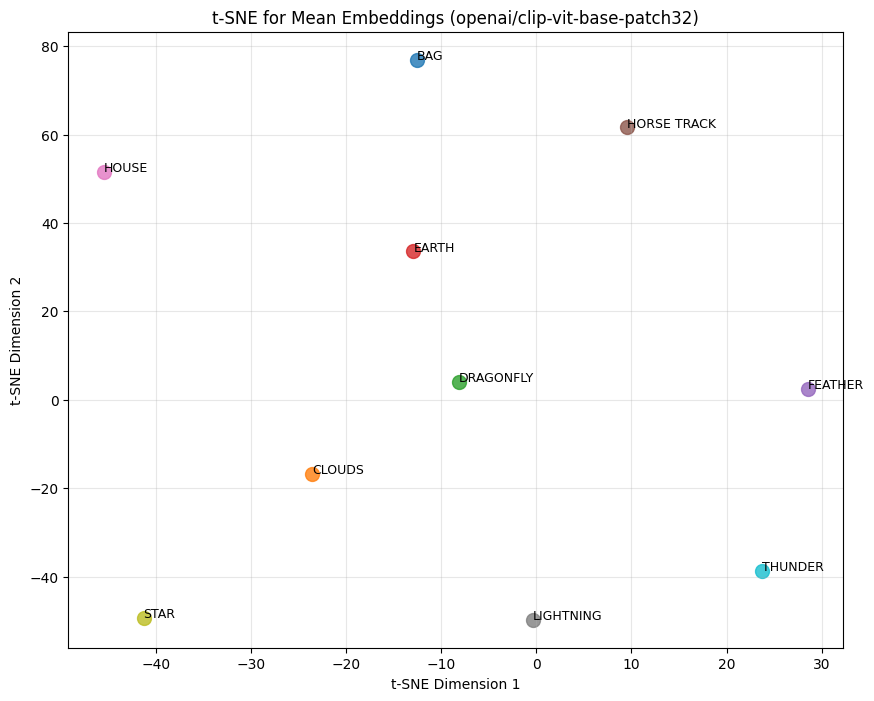

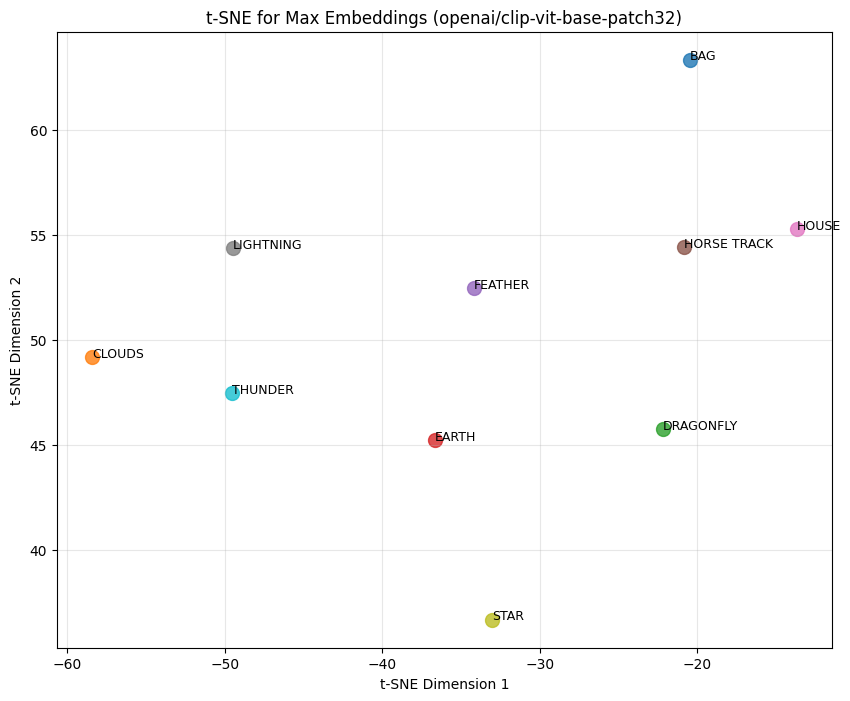

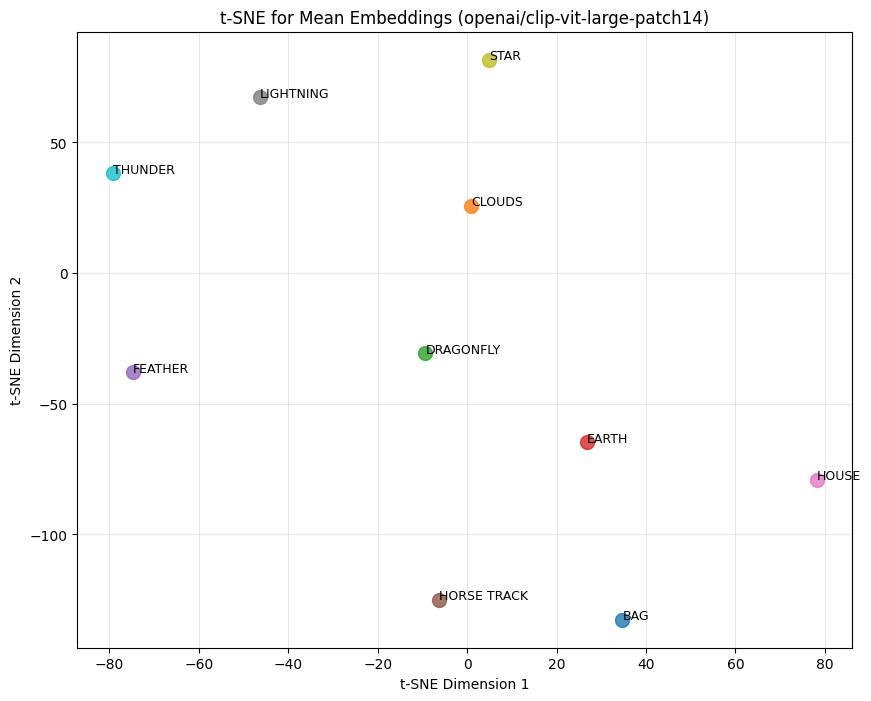

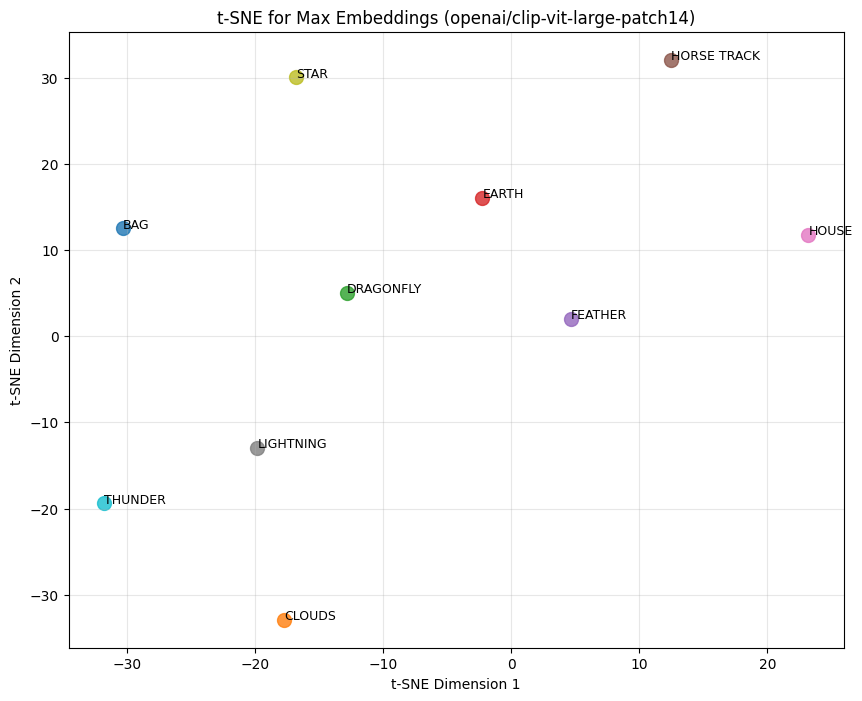

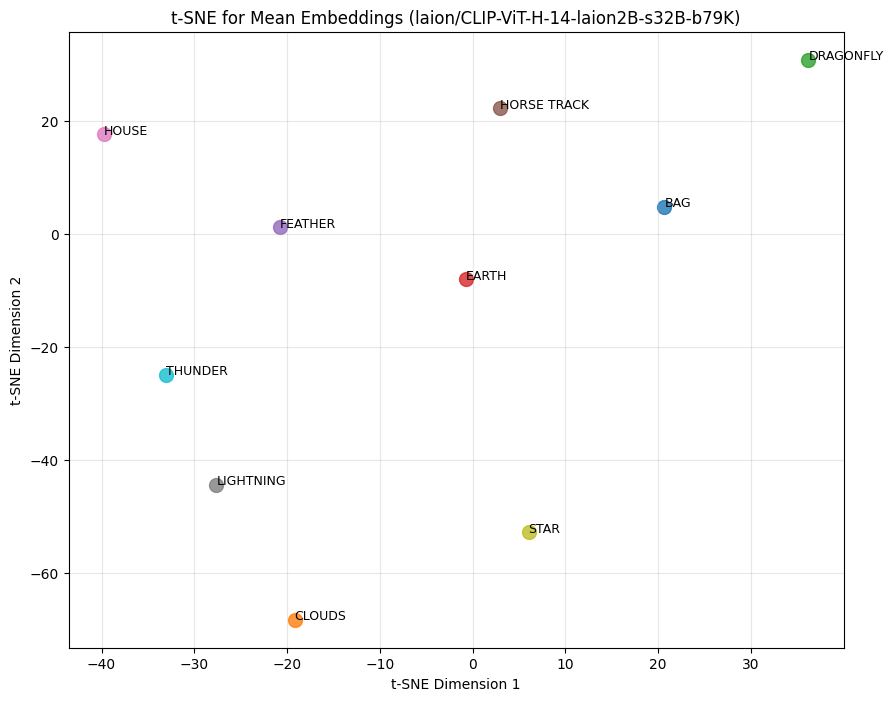

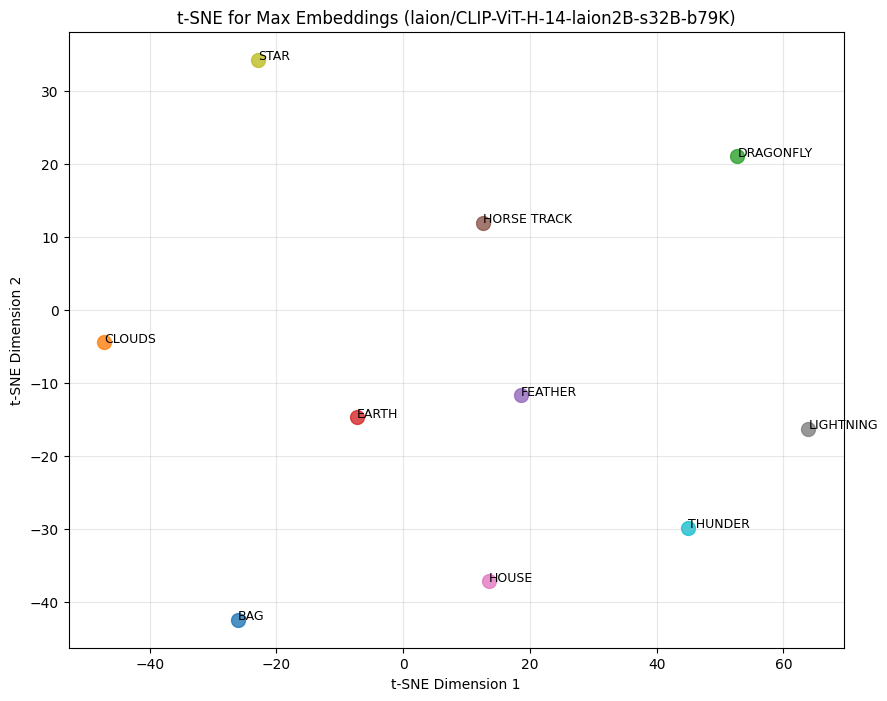

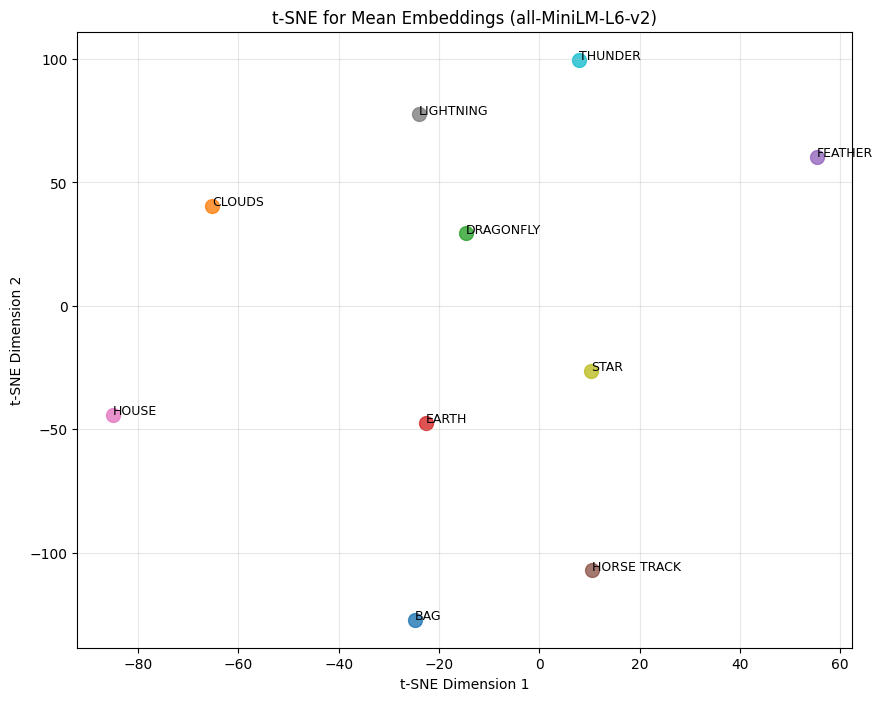

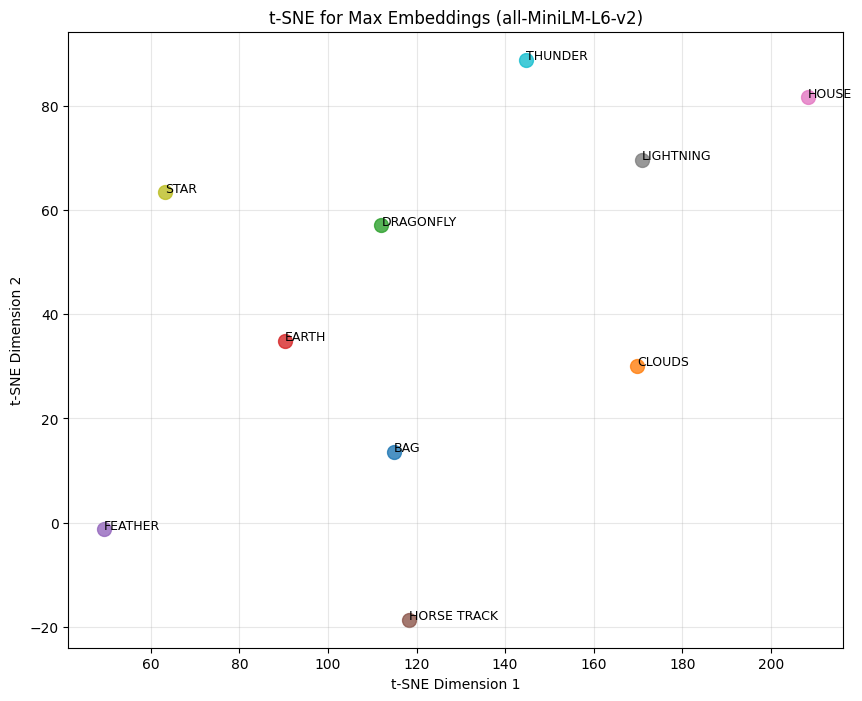

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import os

# Labels for the symbols in order
symbol_labels = [
    "BAG", "CLOUDS", "DRAGONFLY", "EARTH", "FEATHER", 
    "HORSE TRACK", "HOUSE", "LIGHTNING", "STAR", "THUNDER"
]

def plot_tsne(embeddings, labels, title, output_path, perplexity=30, n_iter=1000):
    """
    Perform t-SNE and plot the 2D results.
    
    Args:
        embeddings (ndarray): Embedding vectors.
        labels (list): Labels for the embeddings.
        title (str): Title of the plot.
        output_path (str): Path to save the plot.
        perplexity (int): t-SNE perplexity parameter.
        n_iter (int): Number of iterations for t-SNE optimization.
    """
    # Perform t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, random_state=42)
    tsne_results = tsne.fit_transform(embeddings)
    
    # Plot the t-SNE results
    plt.figure(figsize=(10, 8))
    for i, label in enumerate(labels):
        plt.scatter(tsne_results[i, 0], tsne_results[i, 1], label=label, alpha=0.8, s=100)
        plt.text(tsne_results[i, 0], tsne_results[i, 1], label, fontsize=9)
    
    plt.title(title)
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.grid(alpha=0.3)
    plt.savefig(output_path)
    plt.show()


def load_and_plot_tsne_separate(mean_dir, max_dir, model_names, perplexity=30, n_iter=1000):
    """
    Load mean and max embedding files and create separate t-SNE plots for each.
    
    Args:
        mean_dir (str): Directory containing mean embedding CSV files.
        max_dir (str): Directory containing max embedding CSV files.
        model_names (list): List of model names used for embeddings.
        perplexity (int): t-SNE perplexity parameter.
        n_iter (int): Number of iterations for t-SNE optimization.
    """
    for model_name in model_names:
        # Load mean and max embeddings
        sanitized_model_name = model_name.replace('/', '_').replace('-', '_')
        mean_csv = os.path.join(mean_dir, f"{sanitized_model_name}_mean_embeddings.csv")
        max_csv = os.path.join(max_dir, f"{sanitized_model_name}_max_embeddings.csv")
        
        if not os.path.exists(mean_csv) or not os.path.exists(max_csv):
            print(f"Files not found for model: {model_name}. Skipping...")
            continue
        
        mean_embeddings = pd.read_csv(mean_csv, header=None).values
        max_embeddings = pd.read_csv(max_csv, header=None).values
        
        # Plot t-SNE for mean embeddings
        plot_tsne(
            embeddings=mean_embeddings,
            labels=symbol_labels,
            title=f"t-SNE for Mean Embeddings ({model_name})",
            output_path=f"tsne_mean_{sanitized_model_name}.png",
            perplexity=perplexity,
            n_iter=n_iter
        )
        
        # Plot t-SNE for max embeddings
        plot_tsne(
            embeddings=max_embeddings,
            labels=symbol_labels,
            title=f"t-SNE for Max Embeddings ({model_name})",
            output_path=f"tsne_max_{sanitized_model_name}.png",
            perplexity=perplexity,
            n_iter=n_iter
        )


# Example Usage
mean_dir = "mean_embeddings"
max_dir = "max_embeddings"
model_names = [
    "openai/clip-vit-base-patch32",
    "openai/clip-vit-large-patch14",
    "laion/CLIP-ViT-H-14-laion2B-s32B-b79K",
    "all-MiniLM-L6-v2"
]

load_and_plot_tsne_separate(mean_dir, max_dir, model_names, perplexity=5, n_iter=1000)


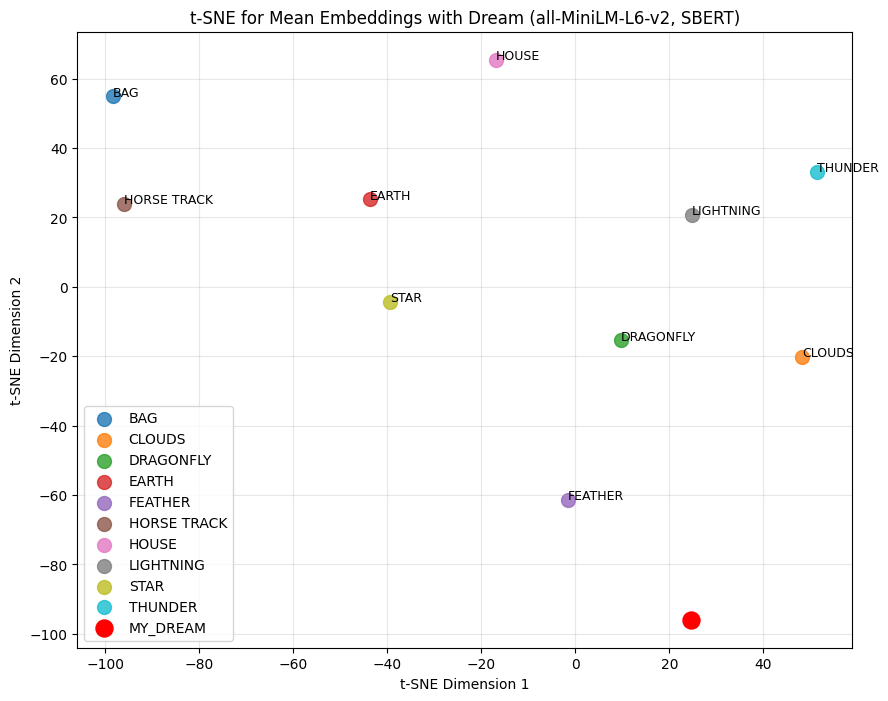

In [4]:
from transformers import CLIPTokenizer, CLIPModel
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import os
import torch

# Labels for the symbols in order, including MY_DREAM
symbol_labels = [
    "BAG", "CLOUDS", "DRAGONFLY", "EARTH", "FEATHER", 
    "HORSE TRACK", "HOUSE", "LIGHTNING", "STAR", "THUNDER", "MY_DREAM"
]

# Define the dream sentence
dream_sentence = "I was the leader of the tribe, guiding my people with wisdom and courage."

def compute_dream_embedding(model_name, sentence, model_type="CLIP"):
    """
    Compute the embedding for the dream sentence using the specified model.
    
    Args:
        model_name (str): Name of the model.
        sentence (str): Dream sentence to embed.
        model_type (str): Type of the model ("CLIP" or "SBERT").
    
    Returns:
        np.ndarray: Embedding vector for the sentence.
    """
    if model_type == "CLIP":
        tokenizer = CLIPTokenizer.from_pretrained(model_name)
        model = CLIPModel.from_pretrained(model_name)
        tokenized = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            embedding = model.get_text_features(**tokenized).squeeze(0).numpy()
    elif model_type == "SBERT":
        model = SentenceTransformer(model_name)
        embedding = model.encode(sentence)
    else:
        raise ValueError("Invalid model_type. Choose 'CLIP' or 'SBERT'.")
    return embedding


def plot_tsne_with_dream(mean_embeddings, dream_embedding, labels, title, output_path, perplexity=30, n_iter=1000):
    """
    Perform t-SNE and plot the 2D results, including the dream embedding.
    
    Args:
        mean_embeddings (ndarray): Mean embedding vectors for symbols.
        dream_embedding (ndarray): Embedding vector for the dream.
        labels (list): Labels for the embeddings.
        title (str): Title of the plot.
        output_path (str): Path to save the plot.
        perplexity (int): t-SNE perplexity parameter.
        n_iter (int): Number of iterations for t-SNE optimization.
    """
    # Add the dream embedding to the mean embeddings
    all_embeddings = np.vstack([mean_embeddings, dream_embedding])
    
    # Perform t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, random_state=42)
    tsne_results = tsne.fit_transform(all_embeddings)
    
    # Plot the t-SNE results
    plt.figure(figsize=(10, 8))
    for i, label in enumerate(labels):
        if label == "MY_DREAM":
            plt.scatter(tsne_results[i, 0], tsne_results[i, 1], label=label, alpha=1.0, s=150, c="red")
        else:
            plt.scatter(tsne_results[i, 0], tsne_results[i, 1], label=label, alpha=0.8, s=100)
            plt.text(tsne_results[i, 0], tsne_results[i, 1], label, fontsize=9)
    
    plt.title(title)
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.savefig(output_path)
    plt.show()


def load_and_plot_tsne_with_dream(mean_dir, model_name, dream_sentence, model_type="CLIP", perplexity=30, n_iter=1000):
    """
    Load mean embedding file, compute dream embedding, and create a t-SNE plot with the dream included.
    
    Args:
        mean_dir (str): Directory containing mean embedding CSV files.
        model_name (str): Name of the model to use.
        dream_sentence (str): Dream sentence to embed.
        model_type (str): Type of the model ("CLIP" or "SBERT").
        perplexity (int): t-SNE perplexity parameter.
        n_iter (int): Number of iterations for t-SNE optimization.
    
    Returns:
        None
    """
    # Load mean embeddings
    sanitized_model_name = model_name.replace('/', '_').replace('-', '_')
    mean_csv = os.path.join(mean_dir, f"{sanitized_model_name}_mean_embeddings.csv")
    
    if not os.path.exists(mean_csv):
        print(f"Mean embedding file not found for model: {model_name}. Skipping...")
        return
    
    mean_embeddings = pd.read_csv(mean_csv, header=None).values
    
    # Compute the embedding for the dream
    dream_embedding = compute_dream_embedding(model_name, dream_sentence, model_type)
    
    # Plot t-SNE with the dream embedding
    plot_tsne_with_dream(
        mean_embeddings=mean_embeddings,
        dream_embedding=dream_embedding,
        labels=symbol_labels,
        title=f"t-SNE for Mean Embeddings with Dream ({model_name}, {model_type})",
        output_path=f"tsne_mean_with_dream_{sanitized_model_name}_{model_type}.png",
        perplexity=perplexity,
        n_iter=n_iter
    )


# Example Usage for CLIP
mean_dir = "mean_embeddings"
clip_model_name = "openai/clip-vit-base-patch32"

# load_and_plot_tsne_with_dream(
#     mean_dir=mean_dir,
#     model_name=clip_model_name,
#     dream_sentence=dream_sentence,
#     model_type="CLIP",
#     perplexity=5,
#     n_iter=1000
# )

# Example Usage for SBERT
sbert_model_name = "all-MiniLM-L6-v2"

load_and_plot_tsne_with_dream(
    mean_dir=mean_dir,
    model_name=sbert_model_name,
    dream_sentence=dream_sentence,
    model_type="SBERT",
    perplexity=5,
    n_iter=1000
)


In [5]:
import numpy as np
import plotly.graph_objects as go
from sklearn.manifold import TSNE
import pandas as pd
import os
from transformers import CLIPTokenizer, CLIPModel
from sentence_transformers import SentenceTransformer
import torch
from scipy.spatial.distance import cdist

# Define a color palette for the symbols
symbol_colors = [
    "#1f77b4",  # Blue
    "#ff7f0e",  # Orange
    "#2ca02c",  # Green
    "#d62728",  # Red
    "#9467bd",  # Purple
    "#8c564b",  # Brown
    "#e377c2",  # Pink
    "#7f7f7f",  # Gray
    "#bcbd22",  # Olive
    "#17becf",  # Cyan
    "#d62728"   # Highlighted Red for MY_DREAM
]

def compute_dream_embedding(model_name, sentence, model_type="CLIP"):
    """
    Compute the embedding for the dream sentence using the specified model.
    """
    if model_type == "CLIP":
        tokenizer = CLIPTokenizer.from_pretrained(model_name)
        model = CLIPModel.from_pretrained(model_name)
        tokenized = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            embedding = model.get_text_features(**tokenized).squeeze(0).numpy()
    elif model_type == "SBERT":
        model = SentenceTransformer(model_name)
        embedding = model.encode(sentence)
    else:
        raise ValueError("Invalid model_type. Choose 'CLIP' or 'SBERT'.")
    return embedding

def plot_tsne_3d_with_links(mean_embeddings, dream_embedding, labels, title, output_path, perplexity=30, n_iter=1000, top_n=3):
    """
    Perform t-SNE and plot the 3D results, including dashed lines linking "MY_DREAM" to the top-N closest symbols.
    """
    # Add the dream embedding to the mean embeddings
    all_embeddings = np.vstack([mean_embeddings, dream_embedding])
    
    # Perform t-SNE in 3D
    tsne = TSNE(n_components=3, perplexity=perplexity, n_iter=n_iter, random_state=42)
    tsne_results = tsne.fit_transform(all_embeddings)
    
    # Split results into X, Y, Z
    x, y, z = tsne_results[:, 0], tsne_results[:, 1], tsne_results[:, 2]
    
    # Compute distances from MY_DREAM to all other points
    dream_idx = len(labels) - 1  # Index of MY_DREAM
    distances = cdist([tsne_results[dream_idx]], tsne_results[:-1])  # Exclude MY_DREAM itself
    closest_indices = distances.argsort()[0][:top_n]  # Indices of top-N closest symbols
    
    # Create a 3D scatter plot
    fig = go.Figure()

    for i, label in enumerate(labels):
        fig.add_trace(go.Scatter3d(
            x=[x[i]], y=[y[i]], z=[z[i]],
            mode='markers+text',
            marker=dict(
                size=25 if label == "MY_DREAM" else 5,
                color=symbol_colors[i],
                opacity=1.0 if label == "MY_DREAM" else 0.8
            ),
            text=[label],
            textposition="top center",
            name=label
        ))
        
    # Add dashed lines connecting MY_DREAM to closest symbols
    for idx in closest_indices:
        fig.add_trace(go.Scatter3d(
            x=[x[dream_idx], x[idx]],
            y=[y[dream_idx], y[idx]],
            z=[z[dream_idx], z[idx]],
            mode='lines',
            line=dict(color="red", dash="dash", width=2),
            showlegend=False
        ))
    
    # Update layout for better visualization
    # Update layout for better visualization
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis=dict(
                title="t-SNE Dimension 1",
                showbackground=False,  # Remove background plane
                showgrid=False,        # Remove gridlines
                zeroline=False         # Remove axis line at zero
            ),
            yaxis=dict(
                title="t-SNE Dimension 2",
                showbackground=False,  # Remove background plane
                showgrid=False,        # Remove gridlines
                zeroline=False         # Remove axis line at zero
            ),
            zaxis=dict(
                title="t-SNE Dimension 3",
                showbackground=False,  # Remove background plane
                showgrid=False,        # Remove gridlines
                zeroline=False         # Remove axis line at zero
            )
        ),
        margin=dict(l=0, r=0, b=0, t=40)
    )
    
    fig.write_html(output_path)
    fig.show()

def load_and_plot_tsne_3d_with_links(mean_dir, model_name, dream_sentence, model_type="CLIP", perplexity=30, n_iter=1000, top_n=3):
    """
    Load mean embedding file, compute dream embedding, and create a 3D t-SNE plot with links to closest symbols.
    """
    # Load mean embeddings
    sanitized_model_name = model_name.replace('/', '_').replace('-', '_')
    mean_csv = os.path.join(mean_dir, f"{sanitized_model_name}_mean_embeddings.csv")
    
    if not os.path.exists(mean_csv):
        print(f"Mean embedding file not found for model: {model_name}. Skipping...")
        return
    
    mean_embeddings = pd.read_csv(mean_csv, header=None).values
    
    # Compute the embedding for the dream
    dream_embedding = compute_dream_embedding(model_name, dream_sentence, model_type)
    
    # Plot t-SNE with the dream embedding and links
    plot_tsne_3d_with_links(
        mean_embeddings=mean_embeddings,
        dream_embedding=dream_embedding,
        labels=symbol_labels,
        title=f"t-SNE 3D with Links ({model_name}, {model_type})",
        output_path=f"tsne_3d_with_links_{sanitized_model_name}_{model_type}.html",
        perplexity=perplexity,
        n_iter=n_iter,
        top_n=top_n
    )


dream_sentence = "My eyes were full of iridiscent colors, and I could see the world in a new light."

mean_dir = "mean_embeddings"
clip_model_name = "openai/clip-vit-base-patch32"

sbert_model_name = "all-MiniLM-L6-v2"

load_and_plot_tsne_3d_with_links(
    mean_dir=mean_dir,
    model_name=sbert_model_name,
    dream_sentence=dream_sentence,
    model_type="SBERT",
    perplexity=7,
    n_iter=1000
)


## Data Augmentation

In [ ]:
import random
from transformers import pipeline
from nltk.corpus import wordnet
import nltk

# Ensure WordNet is downloaded for synonym replacement
nltk.download('wordnet')
nltk.download('omw-1.4')

# Load the paraphrasing model
paraphraser = pipeline("text2text-generation", model="t5-small", device=-1)  # Use CPU, replace with GPU if available


# 1. Synonym Replacement
def synonym_replacement(sentence, n=2):
    """Replace up to n words in the sentence with synonyms."""
    words = sentence.split()
    new_words = words.copy()
    replace_indices = random.sample(range(len(words)), min(n, len(words)))  # Random positions to replace
    
    for idx in replace_indices:
        synonyms = wordnet.synsets(words[idx])  # Find synonyms
        #print(synonyms)
        if synonyms:
            try:
                synonym = synonyms[1].lemmas()[0].name().replace("_", " ")  # Replace with first synonym
            except:
                synonym = synonyms[0].lemmas()[0].name().replace("_", " ")  # Replace with first synonym
            new_words[idx] = synonym  # Replace by position
    
    return ' '.join(new_words)



# 2. Paraphrasing
def paraphrase_sentence(sentence, num_return_sequences=3):
    """Generate paraphrased versions of a sentence using beam search."""
    try:
        outputs = paraphraser(
            sentence,
            max_length=30,
            num_return_sequences=num_return_sequences,
            num_beams=num_return_sequences,  # Enable beam search
            early_stopping=True
        )
        return [output['generated_text'] for output in outputs]
    except Exception as e:
        print(f"Paraphrasing failed for sentence: {sentence}. Error: {e}")
        return [sentence]


# 4. Word Order Shuffling
def shuffle_words(sentence):
    """Shuffle the words in a sentence."""
    words = sentence.split()
    random.shuffle(words)
    return ' '.join(words)


# Main Augmentation Function
def augment_sentences_for_symbols(word_dict, num_sentences=30):
    """
    Create a dictionary with augmented sentences for each symbol.
    
    Args:
        word_dict (dict): Dictionary of symbols and associated words.
        num_sentences (int): Number of augmented sentences per symbol.
    
    Returns:
        dict: A dictionary with symbols as keys and a list of augmented sentences as values.
    """
    augmented_dict = {}

    for symbol, words in word_dict.items():
        base_sentence = " ".join(words)  # Combine words into a base sentence
        augmented_sentences = set()  # Use a set to avoid duplicates
        
        # Add original sentence
        augmented_sentences.add(base_sentence)

        # Generate augmented sentences
        while len(augmented_sentences) < num_sentences:
            # Apply Synonym Replacement
            augmented_sentences.add(synonym_replacement(base_sentence, n=random.randint(1, 3)))
            print(augmented_sentences)
            print(len(augmented_sentences))
            # Apply Paraphrasing
            for paraphrased in paraphrase_sentence(base_sentence, num_return_sequences=3):
                augmented_sentences.add(paraphrased)
                if len(augmented_sentences) >= num_sentences:
                    break

            # Apply Word Order Shuffling
            augmented_sentences.add(shuffle_words(base_sentence))
        
        # Ensure exactly num_sentences
        augmented_dict[symbol] = list(augmented_sentences)[:num_sentences]

    return augmented_dict


# Example Input
lakota_symbols = {
    "BAG": ["purpose", "treasure", "hidden potential"],
    "CLOUDS": ["impermanence", "veil", "drift", "illumination"],
    "DRAGONFLY": ["agility", "metamorphosis", "firelight"],
}

# Run Augmentation
augmented_sentences_dict = augment_sentences_for_symbols(lakota_symbols, num_sentences=10)

# Print Results
for symbol, sentences in augmented_sentences_dict.items():
    print(f"\nSymbol: {symbol}")
    for i, sentence in enumerate(sentences, 1):
        print(f"{i}. {sentence}")


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


{'purpose treasure hidden potential', 'purpose treasure hidden electric potential'}
2
{'treasure potential hidden purpose', 'Paraphrasephrase', 'purpose treasure hidden electric potential', 'paraphrasephrase', 'Paraphrase', 'purpose treasure hidden potential', 'function gem hide potential'}
7
{'treasure potential hidden purpose', 'Paraphrasephrase', 'purpose treasure hidden electric potential', 'treasure purpose hidden potential', 'paraphrasephrase', 'Paraphrase', 'purpose treasure hidden potential', 'function gem hide potential', 'function treasure hide electric potential'}
9
{'impermanence veil drift illumination'}
1
{'', 'paraphrase:', 'impermanence veil drift illumination', 'paraphrase', 'impermanence drift veil illumination'}
5
{'', 'paraphrase:', 'impermanence veil drift illumination', 'paraphrase', 'illumination drift impermanence veil', 'impermanence drift veil illumination'}
6
{'', 'drift illumination veil impermanence', 'paraphrase:', 'impermanence veil drift illumination', '

In [83]:
def paraphrase_sentence(sentence, num_return_sequences=3):
    """Generate paraphrased versions of a sentence using beam search."""
    try:
        outputs = paraphraser(
            sentence,
            max_length=10,
            num_return_sequences=num_return_sequences,
            num_beams=num_return_sequences,  # Enable beam search
            early_stopping=False
        )
        return [output['generated_text'] for output in outputs]
    except Exception as e:
        print(f"Paraphrasing failed for sentence: {sentence}. Error: {e}")
        return [sentence]

sentence = "I am tired of jumping"
paraphrase_sentence(sentence, num_return_sequences=2)

['Ich bin tired of jumping.', 'Ich bin tired of jumping. jumping.']